# Dask Clients

In [1]:
from dask.distributed import Client

In [2]:
client = Client(processes=False, threads_per_worker=4,
                n_workers=32, memory_limit='32GB')
client

Client Scheduler: inproc://35.9.36.219/1985851/1 Dashboard: http://35.9.36.219:8787/status,Cluster Workers: 32 Cores: 128 Memory: 1.02 TB


# Dask Arrays

In [3]:
import dask.array as da
N = int(1e9)

In [23]:
some_data = da.random.random(N, chunks=(int(1e8)))

some_data

dask.array<random_sample, shape=(1000000000,), dtype=float64, chunksize=(100000000,), chunktype=numpy.ndarray>

In [5]:
modified_data = some_data * some_data

data_mean = modified_data.mean()

data_mean

dask.array<mean_agg-aggregate, shape=(), dtype=float64, chunksize=(), chunktype=numpy.ndarray>

In [6]:
data_mean.compute()

0.333333545898394

## For Comparison

In [7]:
import numpy as np

In [8]:
new_data = np.random.random(N)
modified_new_data = new_data * new_data

new_data_mean = modified_new_data.mean()

new_data_mean

0.3333400151789597

Look how much data we're using up!

In [9]:
del new_data
del modified_new_data

## More Complex Example

In [11]:
x_grid, y_grid = da.meshgrid(*[da.linspace(-3,3,1000)]*2)

In [12]:
image = da.sin(3*x_grid) + da.cos(9*y_grid)
image[image<0] = 0
image[(image > 0) & (image < 0.707)] = 2.0

Populating the interactive namespace from numpy and matplotlib


<IPython.core.display.Javascript object>


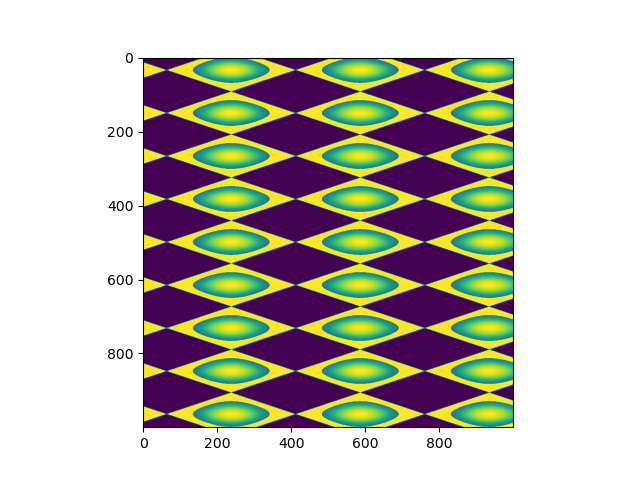

In [13]:
%pylab notebook
plt.imshow(image.compute())

In [14]:
def gaussian(x, y, x0, y0, sigmax, sigmay):
    
    kernel = da.exp(-((x-x0)**2/(2*sigmax**2)+(y-y0)**2/(2*sigmay**2)))
    return kernel / da.sum(kernel)
    
def da_convolve(image, kernel):
    
    s1 = np.array(image.shape)
    s2 = np.array(kernel.shape)
    
    size = s1 + s2 - 1
    
    image_f = da.fft.fft2(image, size)
    kernel_f = da.fft.fft2(kernel, size)
    
    conv = da.fft.ifft2(image_f*kernel_f)[s2[0]//2-1:-s2[0]//2, s2[1]//2-1:-s2[1]//2]
    
    return da.absolute(conv)

In [15]:
kernel = gaussian(x_grid, y_grid, 0, 0, 0.02, 0.05)

Populating the interactive namespace from numpy and matplotlib


<IPython.core.display.Javascript object>


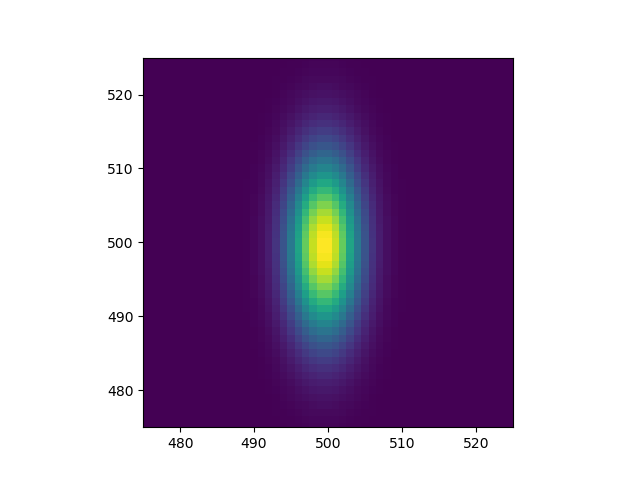

(475.0, 525.0)

In [16]:
%pylab notebook

plt.imshow(kernel.compute())
plt.xlim(475, 525)
plt.ylim(*plt.gca().get_xlim())

In [17]:
smoothed_image = da_convolve(image, kernel)

Populating the interactive namespace from numpy and matplotlib


<IPython.core.display.Javascript object>


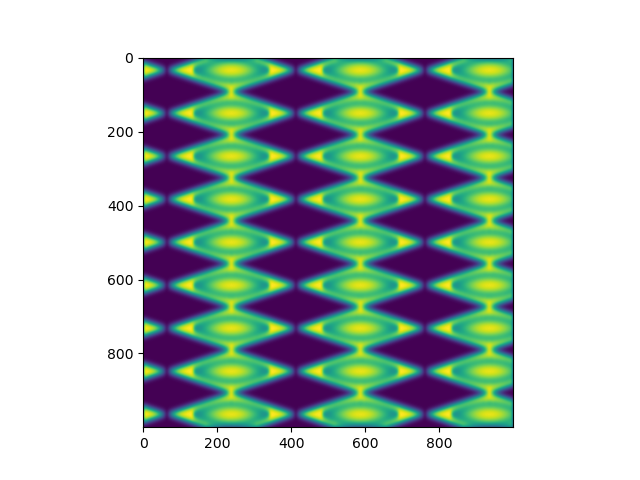

In [18]:
%pylab notebook

plt.imshow(smoothed_image.compute())

In [19]:
kernel_upper = gaussian(x_grid, y_grid, 0, 0, 0.0015, 0.0015)
kernel_lower = gaussian(x_grid, y_grid, 0, 0, 0.001, 0.001)
edge_kernel = kernel_upper - kernel_lower
sharp_image = da.log(da_convolve(image, edge_kernel))

Populating the interactive namespace from numpy and matplotlib


<IPython.core.display.Javascript object>


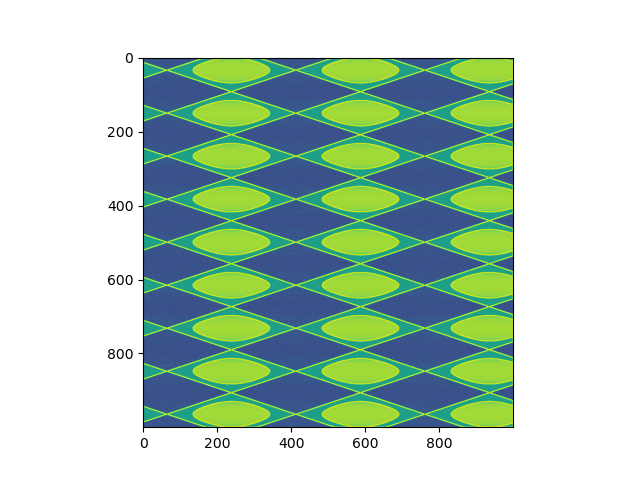

In [20]:
%pylab notebook

plt.imshow(sharp_image.compute().real)